# Near duplicates detection

We are going to find, in an approximated way, all near-duplicate documents inside a collection of documents.

These constraints **must** be satisfied while carrying out the current taask:

  * We will consider Near-duplicates all those pair of documents that have a __Jaccard similarity__ greater than or equal to 0.93
  * Each set of __shingles__, that represents an original document, must be sketched in a __Min-Hashing__ sketch with a length of at most 332
  * The probability to have as a near-duplicate candidate a pair of documents with Jaccard=0.93 must be > 0.96
  * The generation process of near-duplicate pairs you implement must generate the smallest amount of both **False-Negatives** and **False-Positives**
  * The running time of all the __LSH process__ (LSH + approximate Jaccard) must be less than 2 minutes.

Import the needed Python packages.

In [ ]:
import pandas as pd
import random
import itertools as it
import time, math
import numpy as np
import csv
import matplotlib.pyplot as plt


#### NDD functions
A range of functions to perform the Near-Duplicates pipeline is provided.


##### Shingling

> The `cleaner` function will remove from a string all the characters that are not in a predefined set of characters of interest. Multiple spaces will be removed automatically. The function will also remove spaces at the start and end of the sentence, and change all the letters to lowercase.

In [ ]:
set__characters_of_interest = set(
    [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
     'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
def cleaner(text, set__characters_of_interest):
    new_text = ""
    previous_copied_character = "a"
    for c_character in text:
        
        c_character = c_character.lower()
        
        if c_character not in set__characters_of_interest:
            c_character = " "
        
        if c_character == " " and c_character == previous_copied_character:
            continue
        
        new_text += c_character
        previous_copied_character = c_character
    new_text = new_text.strip()
    return new_text

> The `get_shingle_id` function will transform a shingle (a tuple of strings) into its shingle id. The `map__shingle__shingle_id` dictionary will handle the mapping.

In [ ]:
def get_shingle_id(shingle):
    global max_shingle_id
    global map__shingle__shingle_id
    shingle_id = map__shingle__shingle_id.get(shingle, -1)
    
    if shingle_id >= 0:
        return shingle_id
    
    max_shingle_id += 1
    shingle_id = max_shingle_id
    map__shingle__shingle_id[shingle] = max_shingle_id
    return shingle_id

> The `shingler` function takes as input a string and (optionally) a shingle width. It splits the string into words, then iterates in groups of the given length, transforming each into its own shingle_id, and finally outputs the set of shingles that constitutes the sentence.

In [ ]:
def shingler(text, width=2):
    set__shingle_id = set()
    tokenized_text = text.split(" ")
    max_index_plus_1 = 1 if len(tokenized_text) <= width else len(tokenized_text) - width +1
    for index in range(max_index_plus_1):
        #
        c_shingle = tuple(tokenized_text[index:index + width])
        shingle_id = get_shingle_id(c_shingle)
        #
        # if shingle_id in set__shingle_id:
        #    print(shingle_id, c_shingle)
        #
        res = set__shingle_id.add(shingle_id)
    return set__shingle_id

> This function will load each sentence inside the input file. The rows of the input file must have two attributes: document_id and document_text. For each record, the text will be processed by the `cleaner` function, turned into shingles by the `shingler` function, and the result will be written in the output file.

In [ ]:
def create_sets_of_shingle_ids(input_file_name, output_file_name,
                               input_file_delimiter='\t', input_file_quotechar='"',
                               set__characters_of_interest=[" "], shingle_width=3,
                               doc_id_column_idx=0, field_column_idx=1):
    
    output_file = open(output_file_name, 'w', encoding="utf-8")
    output_file_csv_writer = csv.writer(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = ['set_id', 'set_of_integers']
    output_file_csv_writer.writerow(header)
    
    input_file = open(input_file_name, 'r', encoding="utf-8")
    input_file_csv_reader = csv.reader(input_file, delimiter=input_file_delimiter, quotechar=input_file_quotechar)
    next(input_file_csv_reader)
    for record in input_file_csv_reader:
        
        doc_id = int(record[doc_id_column_idx])
        document = record[field_column_idx]
        
        cleaned_document = cleaner(document, set__characters_of_interest)
        set__shingle_id = shingler(cleaned_document, width=shingle_width)
        output_file_csv_writer.writerow([doc_id, set__shingle_id])

        if doc_id % 1000 == 0:
            print("Last processed doc_id:", doc_id)
        
    input_file.close()
    output_file.close()
    print("Last processed doc_id:", doc_id)
    print()
    print("max_shingle_id=", max_shingle_id)
    print()
    print()
    return max_shingle_id


##### MinWise Hashing

> This simple function will (smartly) check if a number is prime.

In [ ]:
def is_prime(number):
    
    if number == 2:
        return True
    if (number % 2) == 0:
        return False
    for j in range(3, int(number ** 0.5 + 1), 2):
        if (number % j) == 0:
            return False
    return True

> The `create_hash_functions` function will take as input the number of hash function desired and the upper bound on the number of distinct elements. It will generate the three values `(a, b, p)` that defines an hash function `number_of_hash_functions` times and return all this information into a dictionary. The optional seed argument will be used to set the random seed, so that the hash function obtained can be controlled.

In [ ]:
def create_hash_functions(number_of_hash_functions, upper_bound_on_number_of_distinct_elements, seed=42):
    random.seed(seed)
    map__hash_function_id__a_b_p = {}
    
    set_of_all_hash_functions = set()
    while len(set_of_all_hash_functions) < number_of_hash_functions:
        a = random.randint(1, upper_bound_on_number_of_distinct_elements - 1)
        b = random.randint(0, upper_bound_on_number_of_distinct_elements - 1)
        p = random.randint(upper_bound_on_number_of_distinct_elements, 10 * upper_bound_on_number_of_distinct_elements)
        while is_prime(p) == False:
            p = random.randint(upper_bound_on_number_of_distinct_elements,
                               10 * upper_bound_on_number_of_distinct_elements)
        
        c_hash_function = (a, b, p)
        set_of_all_hash_functions.add(c_hash_function)
    
    for c_hash_function_id, c_hash_function in enumerate(set_of_all_hash_functions):
        map__hash_function_id__a_b_p[c_hash_function_id] = c_hash_function
    
    return map__hash_function_id__a_b_p

> The `create_c_set_MinWiseHashing_sketch` function will receive as input a set of shingles, a list of hash functions parameters and the total number of hash functions to use. For each hash function, it applies it to each shingle and keeps the minimum value. It gives as output the MinWiseHashing sketch as a list.

In [ ]:
def create_c_set_MinWiseHashing_sketch(c_set,
                                       map_as_list__index__a_b_p,
                                       total_number_of_hash_functions, use_numpy_version = True):
    if use_numpy_version:
      app = np.array(map_as_list__index__a_b_p)
      c_set_MinWiseHashing_sketch = list(np.min((app[:,:1]*np.array(list(c_set))[None,:]+app[:,1:2])%app[:,2:],axis=1))
    else:
      plus_inf = float("+inf")
      c_set_MinWiseHashing_sketch = [plus_inf] * total_number_of_hash_functions
      for c_element_id in c_set:
          for index, (a, b, p) in enumerate(map_as_list__index__a_b_p):
              c_hash_value = (a * c_element_id + b) % p
              if c_hash_value < c_set_MinWiseHashing_sketch[index]:
                  c_set_MinWiseHashing_sketch[index] = c_hash_value

    return c_set_MinWiseHashing_sketch

> The `create_MinWiseHashing_sketches` function first generates the list of hash functions. Then it iterates through the input file containing the set of shingles for each document, computing the MinWiseHashing sketch for each set of shingles and storing this information into a dictionary. This variable is then saved into an output file.

In [ ]:
def create_MinWiseHashing_sketches(input_file_name, upper_bound_on_number_of_distinct_elements,
                                   number_of_hash_functions_that_is_also_the_sketch_lenght_and_also_the_number_of_simulated_permutations,
                                   output_file_name, use_numpy_version=True):
    
    map__hash_function_id__a_b_p = create_hash_functions(
        number_of_hash_functions_that_is_also_the_sketch_lenght_and_also_the_number_of_simulated_permutations,
        upper_bound_on_number_of_distinct_elements)
    map__set_id__MinWiseHashing_sketch = {}
    
    total_number_of_hash_functions = len(map__hash_function_id__a_b_p)
    # sorted_list_all_hash_function_id = sorted(map__hash_function_id__a_b_p.keys())
    map_as_list__index__a_b_p = tuple([(a, b, p) for a, b, p in map__hash_function_id__a_b_p.values()])
    
    input_file = open(input_file_name, 'r', encoding="utf-8")
    input_file_csv_reader = csv.reader(input_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = next(input_file_csv_reader)
    num_record_so_far = 0
    for record in input_file_csv_reader:
      num_record_so_far += 1
      if num_record_so_far % 100 == 0:
          print(num_record_so_far)
      c_set_id = int(record[0])
      c_set = eval(record[1])

      c_set_MinWiseHashing_sketch = create_c_set_MinWiseHashing_sketch(c_set,map_as_list__index__a_b_p,
                                                                       total_number_of_hash_functions,
                                                                       use_numpy_version)
      
      #print(len(c_set_MinWiseHashing_sketch))
      map__set_id__MinWiseHashing_sketch[c_set_id] = c_set_MinWiseHashing_sketch
    input_file.close()
    
    output_file = open(output_file_name, 'w', encoding="utf-8")
    output_file_csv_writer = csv.writer(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = ['set_id', 'MinWiseHashing_sketch']
    output_file_csv_writer.writerow(header)
    sorted_list_all_set_id = sorted(map__set_id__MinWiseHashing_sketch.keys())
    for c_set_id in sorted_list_all_set_id:
        output_file_csv_writer.writerow([c_set_id, str(map__set_id__MinWiseHashing_sketch[c_set_id])])
    output_file.close()
    
    return


##### Locality-Sensitive Hashing

> This function will simply load the MinWiseHashing sketches from the given input file.

In [ ]:
def load_map__set_id__MinWiseHashing_sketch_from_file(input_file_name):
    map__set_id__MinWiseHashing_sketch = {}
    #
    input_file = open(input_file_name, 'r', encoding="utf-8")
    input_file_csv_reader = csv.reader(input_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = next(input_file_csv_reader)
    for record in input_file_csv_reader:
        c_set_id = int(record[0])
        c_MinhiseHashing_sketch = tuple(eval(record[1]))
        map__set_id__MinWiseHashing_sketch[c_set_id] = c_MinhiseHashing_sketch
        
    input_file.close()
    #
    return map__set_id__MinWiseHashing_sketch

> The function computes the sets of unordered couples of document identifiers for which there is at least one band in common between the MinWiseHashing sketches. It takes in input the number or rows and the number of bands and the MinWiseHashing sketches. The number of rows (r) multiplied by the number of bands (b) must be equal to the size of the sketches (n): r*b = n.

In [ ]:
def get_set_of_CANDIDATES_to_be_near_duplicates(r, b, map__set_id__MinWiseHashing_sketch):
    
    set_of_CANDIDATES_to_be_near_duplicates = set()
    
    for c_band_progressive_id in range(b):
        
        print("c_band_progressive_id", c_band_progressive_id)
        
        c_band_starting_index = c_band_progressive_id * r
        c_band_ending_index = (c_band_progressive_id + 1) * r
        
        map__band__set_set_id = {}
        
        for c_set_id in map__set_id__MinWiseHashing_sketch:
            
            if r * b != len(map__set_id__MinWiseHashing_sketch[c_set_id]):
                n = len(map__set_id__MinWiseHashing_sketch[c_set_id])
                message = "ERROR!!! n != r*b " + str(n) + "!=" + str(r * b) + "; " + str(n) + "!=" + str(r) + "*" + str(
                    b)
                raise ValueError(message)
            c_band_for_c_set = tuple(
                map__set_id__MinWiseHashing_sketch[c_set_id][c_band_starting_index:c_band_ending_index])
            if c_band_for_c_set not in map__band__set_set_id:
                map__band__set_set_id[c_band_for_c_set] = set()
            map__band__set_set_id[c_band_for_c_set].add(c_set_id)
            

        for c_set_set_id in map__band__set_set_id.values():
            if len(c_set_set_id) > 1:
                
                for set_id_a, set_id_A in it.combinations(c_set_set_id, 2):
                    if set_id_a < set_id_A:
                        set_of_CANDIDATES_to_be_near_duplicates.add((set_id_a, set_id_A))
                    else:
                        set_of_CANDIDATES_to_be_near_duplicates.add((set_id_A, set_id_a))
    
    return set_of_CANDIDATES_to_be_near_duplicates

> Given two MinWiseHashing sketches, this function will iterate through each of them, counting how many items are equal. Then, it will output this count divided by the length of the sketches.

In [ ]:
def compute_approximate_jaccard(set_a_MinWiseHashing_sketch, set_b_MinWiseHashing_sketch):
    appx_jaccard = 0.
    
    for index in range(len(set_a_MinWiseHashing_sketch)):
        
        if set_a_MinWiseHashing_sketch[index] == set_b_MinWiseHashing_sketch[index]:
            appx_jaccard += 1
        
    appx_jaccard /= len(set_a_MinWiseHashing_sketch)
    
    return appx_jaccard

> Given a Jaccard Threshold, this function will iterate through the list of near duplicates CANDIDATES, computing for each of them the approximate jaccard. If this value overcomes the threshold, the candidate pair is added to a dictionary to be returned.

In [ ]:
def compute_approximate_jaccard_to_REDUCE_the_number_of_CANDIDATES_to_be_near_duplicates(
        set_of_CANDIDATES_to_be_near_duplicates,
        map__set_id__MinWiseHashing_sketch, jaccard_threshold):
    map__set_a_id__set_A_id__appx_jaccard = {}
    
    for set_a_id, set_A_id in set_of_CANDIDATES_to_be_near_duplicates:
        
        set_a_MinWiseHashing_sketch = map__set_id__MinWiseHashing_sketch[set_a_id]
        set_A_MinWiseHashing_sketch = map__set_id__MinWiseHashing_sketch[set_A_id]
        
        appx_jaccard = compute_approximate_jaccard(set_a_MinWiseHashing_sketch, set_A_MinWiseHashing_sketch)
        
        if appx_jaccard >= jaccard_threshold:
            map__set_a_id__set_A_id__appx_jaccard[(set_a_id, set_A_id)] = appx_jaccard
        
    
    return map__set_a_id__set_A_id__appx_jaccard

> This function simply calls all the four previous functions in order; loads the MinWiseHashing sketches, gets the CANDIDATES to be near-duplicates and computes the approximate Jaccard to REDUCE the number of CANDIDATES.

In [ ]:
def mine_couples_of_Near_Duplicates(input_file_name, r, b, jaccard_threshold):
    
    print("Starting the loading of the MinWiseHashing sketches from the input file.")
    map__set_id__MinWiseHashing_sketch = load_map__set_id__MinWiseHashing_sketch_from_file(input_file_name)
    print()
    print("Number of sets=", len(map__set_id__MinWiseHashing_sketch))
    print()
    
    print("Starting the mining of the CANDIDATES couples to be near duplicates.")
    set_of_CANDIDATES_to_be_near_duplicates = get_set_of_CANDIDATES_to_be_near_duplicates(r, b,
                                                                                          map__set_id__MinWiseHashing_sketch)
    
    print()
    print("Number of pairs of sets to be near-duplicate CANDIDATES=", len(set_of_CANDIDATES_to_be_near_duplicates))
    print()
    #
    map__set_a_id__set_A_id__appx_jaccard = compute_approximate_jaccard_to_REDUCE_the_number_of_CANDIDATES_to_be_near_duplicates(
        set_of_CANDIDATES_to_be_near_duplicates, map__set_id__MinWiseHashing_sketch, jaccard_threshold)
    print()
    print("Number of REFINED pairs of sets to be near-duplicate CANDIDATES=",
          len(map__set_a_id__set_A_id__appx_jaccard))
    print()
    
    output_file = open(output_file_name, 'w', encoding="utf-8")
    output_file_csv_writer = csv.writer(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = ['set_a_id', 'set_b_id', 'approximate_jaccard']
    output_file_csv_writer.writerow(header)
    sorted_list_all_set_id = sorted(map__set_id__MinWiseHashing_sketch.keys())
    for set_a_id__set_A_id in map__set_a_id__set_A_id__appx_jaccard:
        appx_jaccard = map__set_a_id__set_A_id__appx_jaccard[set_a_id__set_A_id]
        output_file_csv_writer.writerow([set_a_id__set_A_id[0], set_a_id__set_A_id[1], appx_jaccard])
    output_file.close()
    return

### 1.1
Download the dataset from the Drive link (code already provided). 

In [ ]:
!gdown 16LQDmla82XFK1B0lr8H9ycm01pxjURXN

Downloading...
From (uriginal): https://drive.google.com/uc?id=16LQDmla82XFK1B0lr8H9ycm01pxjURXN
From (redirected): https://drive.google.com/uc?id=16LQDmla82XFK1B0lr8H9ycm01pxjURXN&confirm=t&uuid=cf96f7ee-a3c4-4298-a984-67e82906b842
To: /content/150K_lyrics_from_MetroLyrics.csv
100% 186M/186M [00:02<00:00, 81.0MB/s]


### 1.2
Inspect the dataset: print the list of fields names. Print the value of the `song` field for the last 3 documents.

In [ ]:
# We open the csv using the pd.read_csv function and save it in dataset
dataset = pd.read_csv("150K_lyrics_from_MetroLyrics.csv")

# We print the fields
print("List of fields: ", list(dataset.columns))


print()
# We print the value of the song field for the last three document
print(f"The value of the artist field for the first document:\n{dataset['song'].tail(3)}")

List of fields:  ['ID', 'song', 'year', 'artist', 'genre', 'lyrics']

The value of the artist field for the first document:
149997    oh-what-a-fool-i-have-been
149998                    lonely-boy
149999               sidewalk-sinner
Name: song, dtype: object


### 1.3
Turn the lyrics field of each document into a sets of shingles of length 4 and save the result to a file named `hw1_set_id_set_of_integers.tsv`

In [ ]:
input_file = "lyrics.tsv"
output_file = "hw1_set_id_set_of_integers.tsv"

dataset[['ID', 'lyrics']].to_csv(input_file, sep="\t", index=False,
                                 encoding='UTF-8', header=False,
                                 quotechar='"')
# shingling
shingle_width = 4
map__shingle__shingle_id = {}
max_shingle_id = -1
max_shingle_id = create_sets_of_shingle_ids(input_file_name=input_file,
                                            output_file_name=output_file,
                                            shingle_width=shingle_width,
                                            set__characters_of_interest=set__characters_of_interest)

Last processed doc_id: 1000
Last processed doc_id: 2000
Last processed doc_id: 4000
Last processed doc_id: 5000
Last processed doc_id: 7000
Last processed doc_id: 9000
Last processed doc_id: 13000
Last processed doc_id: 14000
Last processed doc_id: 16000
Last processed doc_id: 17000
Last processed doc_id: 18000
Last processed doc_id: 19000
Last processed doc_id: 22000
Last processed doc_id: 25000
Last processed doc_id: 26000
Last processed doc_id: 27000
Last processed doc_id: 29000
Last processed doc_id: 31000
Last processed doc_id: 33000
Last processed doc_id: 34000
Last processed doc_id: 36000
Last processed doc_id: 37000
Last processed doc_id: 38000
Last processed doc_id: 40000
Last processed doc_id: 42000
Last processed doc_id: 43000
Last processed doc_id: 44000
Last processed doc_id: 46000
Last processed doc_id: 47000
Last processed doc_id: 48000
Last processed doc_id: 49000
Last processed doc_id: 50000
Last processed doc_id: 52000
Last processed doc_id: 53000
Last processed doc_i

### 1.4
Load the file containing the sets of shingles and apply MinWiseHashing, saving the result into a file named `hw1_set_id_MinWiseHashing_sketch.tsv`. We choose the number of hash functions (n) in relation to the constraints highlighted at the beginning.

We have chosen $n=240$ because we wanted to minimize the number of possible false negatives, for this reason we want a low $r$, and $240$ is the only number with $r=3$ that runs in under 2 minutes. 

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

In [ ]:
max_length = 240

input_file = "hw1_set_id_set_of_integers.tsv"
output_file = "hw1_set_id_MinWiseHashing_sketch.tsv"

create_MinWiseHashing_sketches(input_file,
                               max_shingle_id,
                               max_length,
                               output_file)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

### 1.5
To perform Locality Sensivity Hashing, we have to choose the number of rows (r) and the number bands (b). We list all the possible choices of r and b that satisfy the constraints highlighted at the beginning, according to the number of hash functions we chose.

For all of these configurations, plot all the associated S-curves. The S-curve is defined as the probability (y-axis) that a pair of documents with Jaccard similarity j (x-axis) is selected as a near-duplicate candidate given r and b. Plot all S-curves in the same plot.

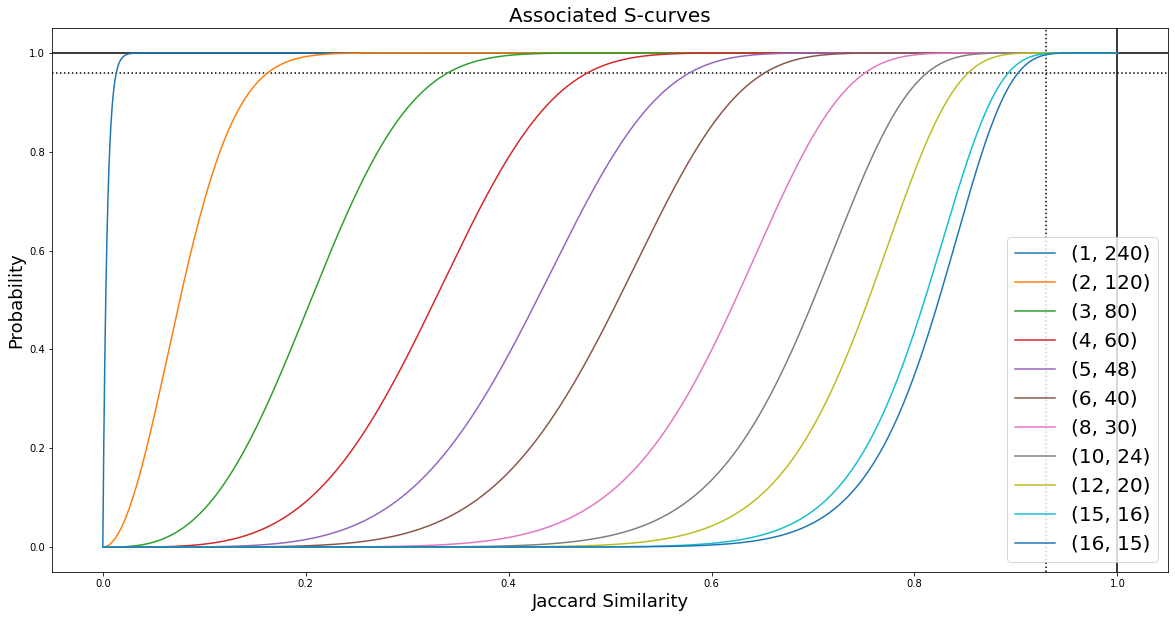

In [ ]:
jaccard_threshold = 0.93; prob = 0.96

def function(x, r, b): return 1-(1-x**r)**b

couples = [] # [(r_1, b_1), ..., (r_n, b_n)] list of couples (r, b)
for i in range(1, int(math.sqrt(max_length) + 1)): # This function populates couples
  if max_length%i == 0: # Check if i is a divisor of the number of hash functions
    if function(jaccard_threshold, i, max_length/i) > prob: couples.append((i, int(max_length/i)))
    if function(jaccard_threshold, max_length/i, i) > prob and i*i != max_length: couples.append((int(max_length/i), i))

x = np.linspace(0, 1, num = 1000)

plt.figure(figsize = (20, 10))
plt.title("Associated S-curves", fontsize=20)
plt.xlabel("Jaccard Similarity", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.axvline(x = jaccard_threshold, color = 'k', linestyle = ':')
plt.axhline(y = prob, color = 'k', linestyle = ':')
plt.axvline(x = 1, color = 'k')
plt.axhline(y = 1, color = 'k')

for couple in couples:
  y = function(x, couple[0], couple[1]) # Add a function y for each couple to our plot
  plt.plot(x, y, label = str(couple))

plt.legend(prop = {'size': 20}) # We plot the legend
plt.show()

### 1.6
Among all the configurations we plotted in the previous step, we choose the one that gives the smallest amount of False-Positives and False-Negatives near-duplicates candidates, satisfying the provided constraints. We take into account that after the LSH procedure, the approximate Jaccard similarity between near-duplicate candidates is computed and used to reduce their number.

In [ ]:
r=3
b=80

Among all the configurations we decided to use $(r,b)=(3,80)$, this one garanties us the smallest amount of False-Negatives and a LSH execution time smaller than the maximum (2 min). With this configuration we'll have a big number of False-Positives, but thanks to the computation of the approximate Jaccard Similarity, we can significantly reduce this number.

### 1.7
Load the file containing the MinWiseHashing sketches and perform Locality Sensivity Hashing, using the parameters we chose in last step, considering also the computation of approximate Jaccard to reduce the number of candidates. Save the Near-Duplicates candidates obtained to a file named `hw1_NearDuplicates_set_a_id_set_b_id_approximate_jaccard.tsv`.

Print the execution time.

In [ ]:
input_file_name = "hw1_set_id_MinWiseHashing_sketch.tsv"
output_file_name = "hw1_NearDuplicates_set_a_id_set_b_id_approximate_jaccard.tsv"


start = time.time()
mine_couples_of_Near_Duplicates(input_file_name, r, b, jaccard_threshold)
end = time.time()



print(f"Execution time: {int((end-start)/60)} min and {(end-start)%60} seconds")

Starting the loading of the MinWiseHashing sketches from the input file.

Number of sets= 149999

Starting the mining of the CANDIDATES couples to be near duplicates.
c_band_progressive_id 0
c_band_progressive_id 1
c_band_progressive_id 2
c_band_progressive_id 3
c_band_progressive_id 4
c_band_progressive_id 5
c_band_progressive_id 6
c_band_progressive_id 7
c_band_progressive_id 8
c_band_progressive_id 9
c_band_progressive_id 10
c_band_progressive_id 11
c_band_progressive_id 12
c_band_progressive_id 13
c_band_progressive_id 14
c_band_progressive_id 15
c_band_progressive_id 16
c_band_progressive_id 17
c_band_progressive_id 18
c_band_progressive_id 19
c_band_progressive_id 20
c_band_progressive_id 21
c_band_progressive_id 22
c_band_progressive_id 23
c_band_progressive_id 24
c_band_progressive_id 25
c_band_progressive_id 26
c_band_progressive_id 27
c_band_progressive_id 28
c_band_progressive_id 29
c_band_progressive_id 30
c_band_progressive_id 31
c_band_progressive_id 32
c_band_progressive

### 1.8
Load the file containing the number of near-duplicates candidates. Print the number of near-duplicates candidates we found.

In [ ]:
print("The number of near-duplicates candidates are:",
      len(pd.read_csv(output_file_name, sep="\t")))

The number of near-duplicates candidates are: 17185


### 1.9

Let us consider the same scenario as in step 1, with the only addition of not wanting more than 100 False Negatives. How would the choice of the LSH configuration change? Would we need any more information to satisfy the new constraint?

The probability of false negatives is given by the following formula: $(1-(j)^r)^b$, where $j$ is the jaccard similarity. In this case we can control the number of false negatives pointwise ESTIMATE controlling the upper bound of the probability of false negatives, i.e. $(1-(θ)^r)^b$, where $θ$ is the (given) threshold jaccard similarity. Considering the fact that each document can be chosen relevant or not independently from the others, we have to choose the possible combination of $r$ and $b$ such that:

$$
\begin{cases}
(1-(θ)^r)^b \cdot n_\text{doc} \le 100\\
n= b \cdot r
\end{cases}
$$

With the combination(s) of $r$ and $b$ that satisfy the above system we can't control the number of false negatives over all the possible values (continuous interval) of the jaccard similarity beyond the 𝜃 threshold!

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>